In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use('fivethirtyeight')

In [2]:
start = '2020-01-01'
end = '2024-02-28'
df = yf.download('THYAO.IS', start=start, end=end)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,14.50,14.84,14.48,14.83,14.83,109370878
2020-01-03,14.67,14.73,14.09,14.27,14.27,153873531
2020-01-06,14.03,14.08,13.50,13.57,13.57,136423179
2020-01-07,13.79,13.86,13.52,13.54,13.54,154729229
2020-01-08,13.05,13.62,13.03,13.50,13.50,197012716
...,...,...,...,...,...,...
2024-02-21,282.50,285.00,277.75,279.25,279.25,33090339
2024-02-22,281.00,287.25,280.75,285.00,285.00,45275866
2024-02-23,286.00,288.00,282.00,286.50,286.50,36388629


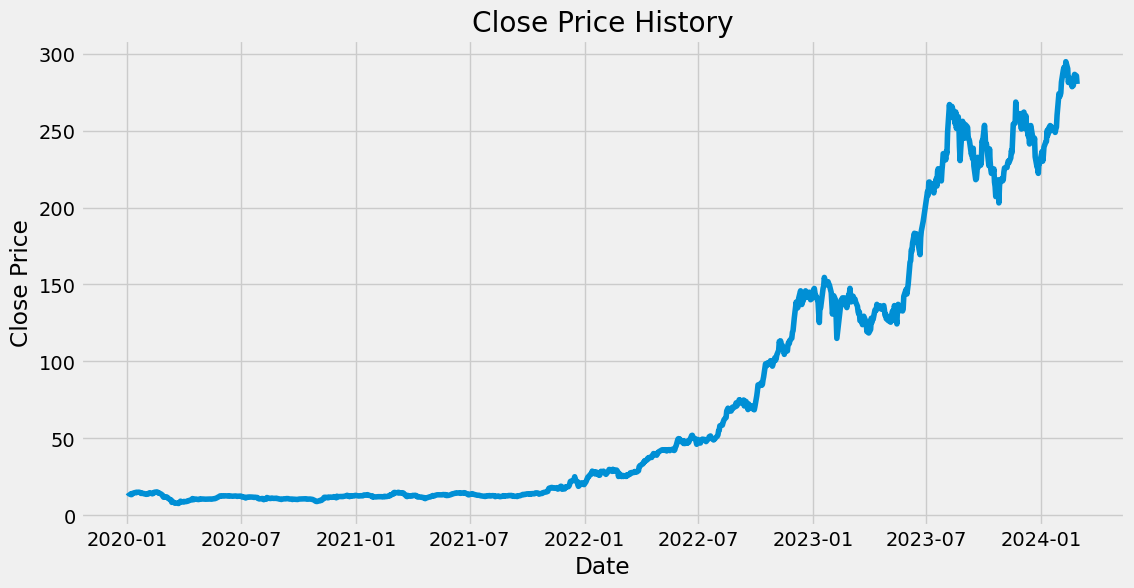

In [3]:
# kapanış verisini tarihe göre görselleştir
plt.figure(figsize=(12, 6))
plt.title("Close Price History")
plt.plot(df['Close'])
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.show()

In [4]:
# kapanış verisini filtrele
data = df.filter(['Close'])
# numpy dizisini dönüştür
dataset = data.values
# eğitim seti oluştur %80'lik
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

835

In [5]:
# veriyi ölçeklendir
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.02470297],
       [0.02275182],
       [0.02031288],
       ...,
       [0.97125536],
       [0.96777116],
       [0.94947911]])

In [6]:
# eğitim veri seti oluştur
# ölçeklendirilmiş eğitim seti oluştur
train_data = scaled_data[0: training_data_len, :]
# X_train and y_train olarak veriyi ikiye böl
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [7]:
#  iki seti de numpy dizisine dönüştür
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
# 3-boyutlu olacak şekilde veriyi yeniden şekillendir
display(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
display(X_train.shape)

(775, 60)

(775, 60, 1)

In [9]:
# LSTM modelini oluştur
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [10]:
# model derleme
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# model eğtimi
model.fit(X_train, y_train, batch_size=1, epochs=1)

775/775 [==============================] - 15s 15ms/step - loss: 9.3291e-04


In [ ]:
# 